# TIME SERIES

<img src="image.jpeg" width="700">

### Objective:  
to forecast new airpassenger for the next months by using a dataset about airpassenger per month 

# Importing libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

# Loading dataset

In [2]:
data = pd.read_csv('data/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# converting columns 'Month' to a suitable datatime for Time Series (year-month-day)
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# EDA

In [6]:
# lines and columns of the dataset
data.shape

(144, 1)

In [8]:
# overview of the dataset (columns, types, memory usage, etc)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [10]:
# checking missing values
data.isnull().sum()

#Passengers    0
dtype: int64

# Checking the concept of Stationary Time Serie

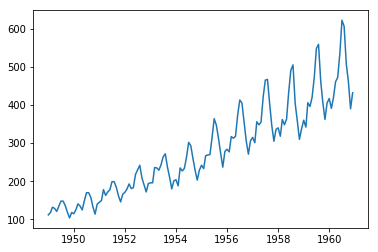

In [39]:
# plotting the original data
plt.plot(data);

In [42]:
# 2 types of stationarity testings
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

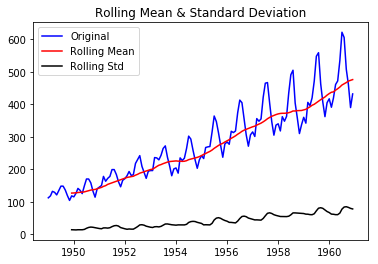

In [43]:
test_stationarity(data)

In [36]:
# 2 types of stationarity testings
from statsmodels.tsa.stattools import adfuller
def test_stationarityFuller(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [37]:
test_stationarityFuller(data['#Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


❌ In the above example, the Test Statistic > Critical Value, which implies that the series is not stationary.

# Turning to Stationary Time Serie

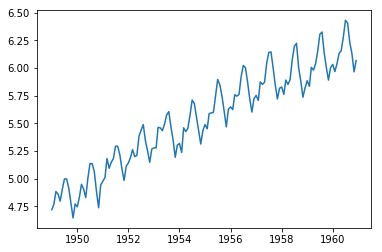

In [45]:
# altering the original scale to log scale
ts_log = np.log(data)
plt.plot(ts_log);

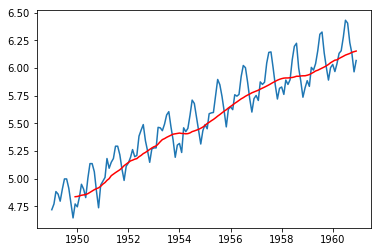

In [47]:
# calculating the moving average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red');

The red line shows the rolling average

In [52]:
# subtracting 'moving average' from dataset transformed to log scale
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


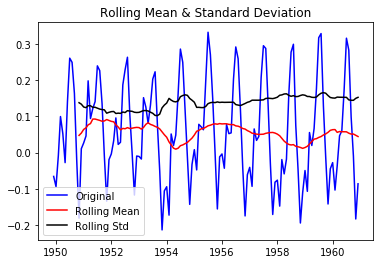

In [53]:
# taking out NAN and testing stationarity once more
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

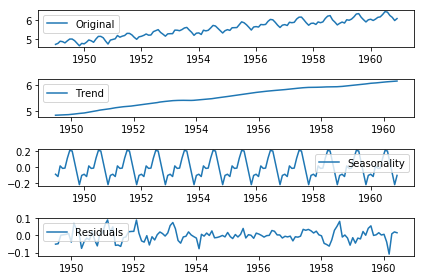

In [56]:
# decomposing the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Loading model


In [60]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff = ts_log_diff.dropna()
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

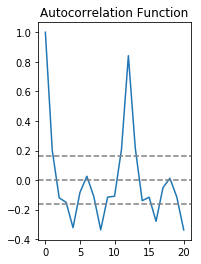

In [61]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

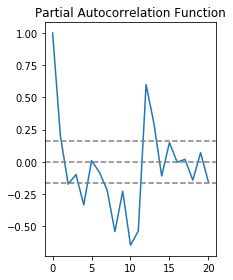

In [62]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [63]:
# loading ARIMA model
from statsmodels.tsa.arima_model import ARIMA

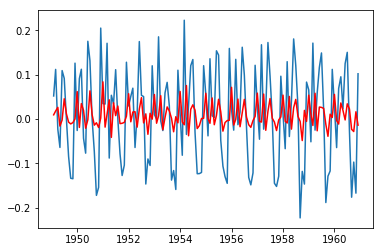

In [70]:
# MODELO AR
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red');

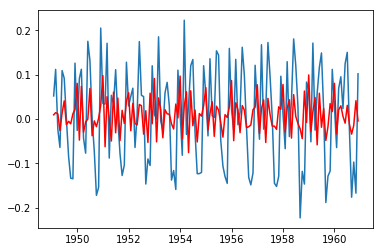

In [71]:
# MODELO MA

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red');

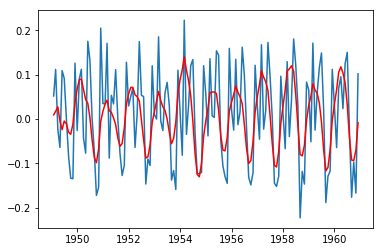

In [72]:
# Combining AR + MA 

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red');

In [74]:
### Seasonality
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(ts_log,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6964      0.251     -2.771      0.006      -1.189      -0.204
ar.L2          0.0865      0.205      0.423      0.673      -0.315       0.488
ma.L1          0.2710      0.221      1.226      0.220      -0.162       0.704
ma.L2         -0.4450      0.167     -2.662      0.008      -0.773      -0.117
ar.S.L12      -0.4651      0.084     -5.523      0.000      -0.630      -0.300
sigma2         0.0014      0.000      8.238      0.000       0.001       0.002


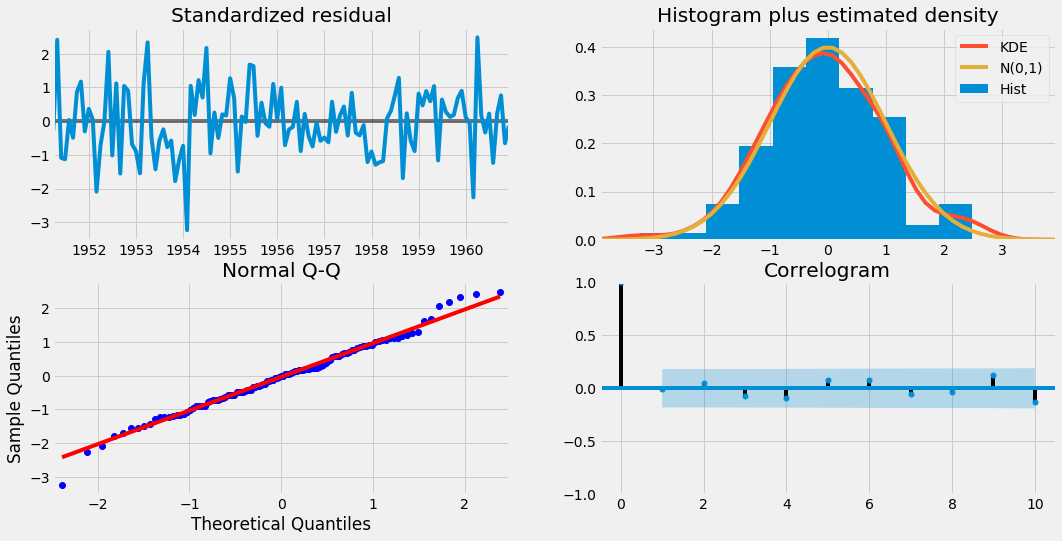

In [77]:
plt.style.use('fivethirtyeight')
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Forecasting

In [83]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

SyntaxError: invalid syntax (<ipython-input-83-572cd420036c>, line 2)

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

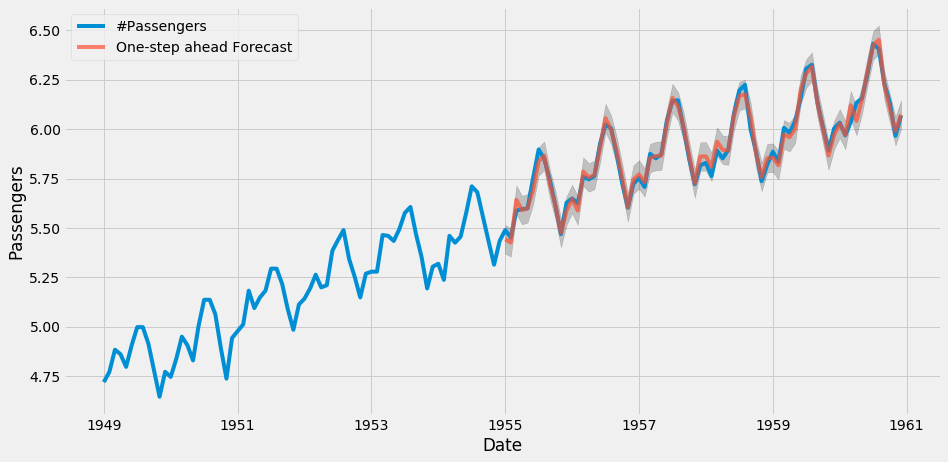

In [78]:
pred = results.get_prediction(start=pd.to_datetime('1955-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts_log['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

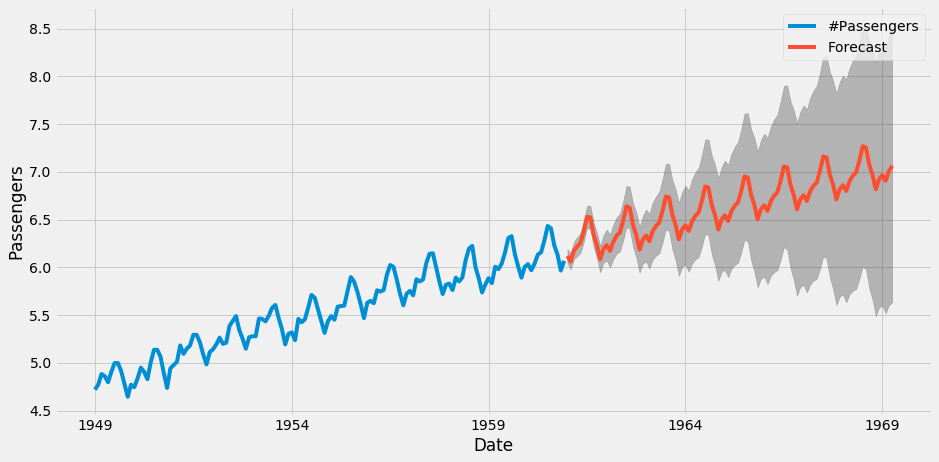

In [79]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts_log.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

# Conclusion

As we can see through forecasting plots the objective of this notebook has been achieved with all the important changes and analysis needed.